In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 35 Lecture 1 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset describing survival rates after breast cancer surgery loaded below and analyze the model generated for this dataset.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# Attributes:
# Age of patient at time of operation (numerical)
# Patient's year of operation (year - 1900, numerical)
# Number of positive axillary nodes detected (numerical)
# Survival status (class attribute)
#  -- 1 = the patient survived 5 years or longer
#  -- 2 = the patient died within 5 year

cols = ["age", "op_year", "nodes", "survival"]
cancer = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/haberman.data",
    names=cols,
)

cancer = cancer.dropna()

# Re-encoding survival as 1s & 0s:
#  * 2 -> 1 (the patient died within 5 year)
#  * 1 -> 0 (the patient survived 5 years or longer)
cancer["survival"] -= 1

# Renaming to reflect update
cancer = cancer.rename(columns={"survival": "lost_battle"})

cancer.head()

,age,op_year,nodes,lost_battle
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0


<IPython.core.display.Javascript object>

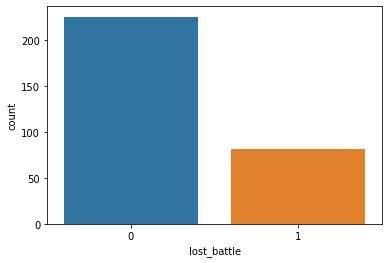

<IPython.core.display.Javascript object>

In [4]:
sns.countplot(cancer["lost_battle"])
plt.show()

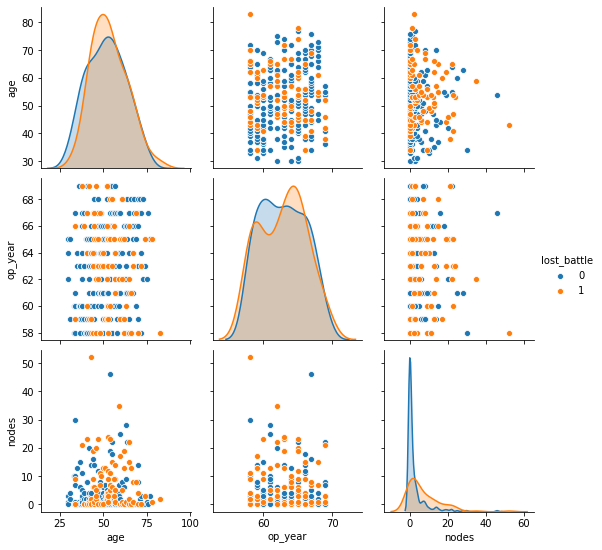

<IPython.core.display.Javascript object>

In [5]:
sns.pairplot(cancer, hue="lost_battle")
plt.show()

Nodes has a lot of variation.  Let's investigate.

The table and scatter plot show that there's some relationship, but once we get past a certain number of nodes we don't have a lot of evidence supporting this claim.

,nodes,death_rate,count
0,0,0.139706,136
1,1,0.195122,41
2,2,0.250000,20
3,3,0.350000,20
4,4,0.230769,13


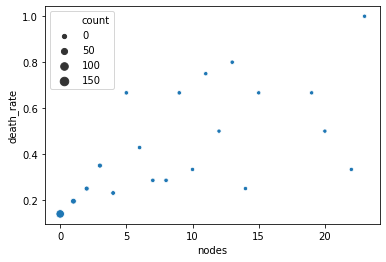

<IPython.core.display.Javascript object>

In [6]:
nodes = cancer[["nodes", "lost_battle"]]

death_rate_by_nodes = nodes.groupby("nodes").agg(["mean", "count"])
death_rate_by_nodes.columns = ["death_rate", "count"]
death_rate_by_nodes = death_rate_by_nodes.reset_index()

# Removing 1-offs that might skew pattern
viz_df = death_rate_by_nodes[death_rate_by_nodes["count"] > 1]
display(viz_df.head())

sns.scatterplot(x="nodes", y="death_rate", size="count", data=viz_df)
plt.show()

Split the data into train and test (20% in test)

In [7]:
X = cancer.drop(columns=["lost_battle"])
y = cancer["lost_battle"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [8]:
y_train.value_counts(normalize=True)

0    0.733607
1    0.266393
Name: lost_battle, dtype: float64

<IPython.core.display.Javascript object>

Create a gradient boosted classification algorithm with a learning rate of 0.01 and max depth of 5. Report the accuracy.

In [9]:
bin_cols = []
num_cols = ["age", "op_year", "nodes"]

<IPython.core.display.Javascript object>

In [10]:
pipeline = Pipeline([("scale", StandardScaler()), ("xgb", XGBClassifier()),])

<IPython.core.display.Javascript object>

In [11]:
pipeline["xgb"].learning_rate = 0.01
pipeline["xgb"].max_depth = 5

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.8278688524590164
test_score: 0.6290322580645161


<IPython.core.display.Javascript object>

Print the confusion matrix for the test data. What do you notice about our predictions?

In [12]:
y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[38,  8],
       [15,  1]])

<IPython.core.display.Javascript object>

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        46
           1       0.11      0.06      0.08        16

    accuracy                           0.63        62
   macro avg       0.41      0.44      0.42        62
weighted avg       0.56      0.63      0.59        62



<IPython.core.display.Javascript object>

Print the confusion matrix for a learning rate of 1 and a learning rate of 0.5. What do you see now that stands out to you in the confusion matrix?

In [14]:
pipeline["xgb"].learning_rate = 1.0
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[37,  9],
       [12,  4]])

<IPython.core.display.Javascript object>

In [15]:
pipeline["xgb"].learning_rate = 0.5
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[37,  9],
       [12,  4]])

<IPython.core.display.Javascript object>

Perform a grid search for the optimal learning rate.

Down sampling majority class (an attempt to address class imbalance)

In [16]:
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

# Making up a limit to how many observations
# the majority class will have.
# Played with the number to end up with 1.3
n_0 = round(X_train_1.shape[0] * 1.2)
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_0, replace=False, random_state=42)

# Re-combine data (using the downsampled X for majority class)
X_train_downsample = pd.concat((X_train_1, X_train_0_sample))
X_train_downsample = X_train_downsample.reset_index(drop=True)

y_train_downsample = np.array([1] * n_1 + [0] * n_0)

<IPython.core.display.Javascript object>

In [17]:
params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__max_features": [0.3, 0.6, 1.0],
    "xgb__max_depth": [3, 4, 5],
}

n_trees = 50
learning_rate = 2 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

<IPython.core.display.Javascript object>

After all that, we were able to barely improve both precision and recall of the minority class by tuning.

In [18]:
pipeline_cv = GridSearchCV(pipeline, params, n_jobs=-1)
pipeline_cv.fit(X_train_downsample, y_train_downsample)

print(pipeline_cv.best_params_)

print(
    f"\nDownsampled train score: {pipeline_cv.score(X_train_downsample, y_train_downsample):.2f}"
)
print(f"Full train score: {pipeline_cv.score(X_train, y_train):.2f}")
print(f"Test score: {pipeline_cv.score(X_test, y_test):.2f}\n")

y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

{'xgb__max_depth': 4, 'xgb__max_features': 0.3, 'xgb__subsample': 0.5}

Downsampled train score: 0.76
Full train score: 0.80
Test score: 0.66

[[35 11]
 [10  6]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        46
           1       0.35      0.38      0.36        16

    accuracy                           0.66        62
   macro avg       0.57      0.57      0.57        62
weighted avg       0.67      0.66      0.66        62



<IPython.core.display.Javascript object>

List the feature importances for the model with the optimal learning rate.

In [19]:
importance_df = pd.DataFrame()
importance_df["feat"] = ["age", "op_year", "nodes"]
importance_df["importance"] = pipeline_cv.best_estimator_["xgb"].feature_importances_
importance_df = importance_df.sort_values("importance", ascending=False)

importance_df

,feat,importance
2,nodes,0.483304
0,age,0.287160
1,op_year,0.229536


<IPython.core.display.Javascript object>